 **FINALE!**

Consider the $\texttt{NBA_DATAMINING.csv}$ dataset, which consists of statistics for thousands of NBA games from 2011 to Today. The goal of this assignment is to be able to predict the winner of any game with better than 50% accuracy [ we sincerely hope you can do better than flipping a coin ;) ].

In [1]:
YOUR_NAME_HERE = 'Andrew Madigan'

The dataset consists of the following columns where $\texttt{o:}$ corresponds to the the "opponent"

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('NBA_DATAMINING.csv')
print(data.columns)

Index(['date', 'team', 'points', 'assists', 'biggest lead', 'blocks',
       'defensive rebounds', 'fast break points', 'field goals attempted',
       'field goals made', 'fouls', 'free throws attempted',
       'free throws made', 'game number', 'lead changes', 'losses', 'margin',
       'margin after the first', 'margin after the third',
       'margin at the half', 'matchup losses', 'matchup wins',
       'offensive rebounds', 'playoffs', 'points in the paint', 'rebounds',
       'rest', 'site', 'site streak', 'steals', 'streak', 'team rebounds',
       'three pointers attempted', 'three pointers made', 'times tied',
       'total', 'turnovers', 'wins', 'o:team', 'o:points', 'o:assists',
       'o:biggest lead', 'o:blocks', 'o:defensive rebounds',
       'o:fast break points', 'o:field goals attempted', 'o:field goals made',
       'o:fouls', 'o:free throws attempted', 'o:free throws made', 'o:losses',
       'margin.1', 'o:margin after the first', 'o:margin after the third',
     

In [314]:
data.head()

,date,team,points,assists,biggest lead,blocks,defensive rebounds,fast break points,field goals attempted,field goals made,...,o:site,o:site streak,o:steals,o:streak,o:team rebounds,o:three pointers attempted,o:three pointers made,o:turnovers,o:wins,season
0,20091115,Lakers,91,23,14,10,32,18,84,32,...,away,-1,9,-1,8,32,9,19,5,2009
1,20091115,Pistons,90,12,7,6,32,6,83,38,...,away,-2,11,1,7,16,7,7,6,2009
2,20091115,Suns,101,18,7,4,34,10,78,35,...,away,-1,6,2,5,24,9,11,5,2009
3,20091115,Thunder,93,13,3,1,30,10,85,33,...,away,4,9,-3,9,17,5,12,3,2009
4,20091116,Bucks,113,26,2,4,33,18,99,44,...,away,-3,5,2,7,20,10,15,7,2009


So each row above is a game with the statistics from the outcome of that game.

In order to predict the winner of any given game, you are $\texttt{NOT}$ allowed to use any data that you would not have in real life prior to the start of a game!!!!! 

ie: $\texttt{points, assists, biggest lead, etc...}$ from the CURRENT GAME/ROW are not allowed as predictors... Only data from PREVIOUS games! That means we're going to have to move some data around...  (this will mostly happen in build_data())

Remember we're trying to emulate real life here, so you cant use data from the future!

 
 
 ** Setting up your data **
 
 SEASONS $\texttt{2011-2016}$ will be used for Training and the $\texttt{2017}$ year will be used for Testing, however this is already done for you. You'll just need to make one big 2D matrix of 
 
    data samples (games) x predictors

and a 1D array of 

    Targets

To begin, lets set up a dictionary where each $\texttt{team}$ is a key in the dictionary where you'll keep track of the performance of each $\texttt{team}$ in each $\texttt{season}$.


In [391]:
#lets just start with a few predictors (you could simply use all of them!!)
predictors = []
# data.columns.values.tolist()
# ['wins','o:wins',              
#               'points','o:points',
#               'assists','o:assists',
#               'turnovers','o:turnovers',
#               'elo',
#               ]
included_predictors = ['wins','o:wins',
                       'win_ratio','o:win_ratio',
                       'points','o:points',
                       'points last 10','o:points last 10',
                       'assists','o:assists',
                       'turnovers','o:turnovers',
                       'streak','o:streak',
                       'offensive rebounds','o:offensive rebounds']
for predictor in included_predictors:
    predictors.append(predictor)

print(predictors)

['wins', 'o:wins', 'win_ratio', 'o:win_ratio', 'points', 'o:points', 'points last 10', 'o:points last 10', 'assists', 'o:assists', 'turnovers', 'o:turnovers', 'streak', 'o:streak', 'offensive rebounds', 'o:offensive rebounds']


In [392]:
# THERE IS NOTHING FOR YOU TO CODE IN THIS CELL, I've written it for you to get you started.

team_season_stats = {}

for season in np.unique(data['season']): #creating a dictionary for each season
    team_season_stats[season] = {} 
    
    for team in np.unique(data['team']): #creating a dictionary for each team
        team_season_stats[season][team] = {} #THIS IS GOING TO CONTAIN THE NAMES OF YOUR PREDICTORS!
        
        for predictor in predictors:
            #FOR EACH PREDICTOR, this is where we're going to keep track of the data from previous games by 
            #appending to these lists
            team_season_stats[season][team][predictor] = [] 

          
            
print('SEASONS',team_season_stats.keys())
print()
print('TEAMS',team_season_stats[2011].keys())

SEASONS dict_keys([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

TEAMS dict_keys(['Bucks', 'Bulls', 'Cavaliers', 'Celtics', 'Clippers', 'Grizzlies', 'Hawks', 'Heat', 'Hornets', 'Jazz', 'Kings', 'Knicks', 'Lakers', 'Magic', 'Mavericks', 'Nets', 'Nuggets', 'Pacers', 'Pelicans', 'Pistons', 'Raptors', 'Rockets', 'Seventysixers', 'Spurs', 'Suns', 'Thunder', 'Timberwolves', 'Trailblazers', 'Warriors', 'Wizards'])


We also need to add a column to determine who won the game (TARGET). Currently we just have the scores of each team

In [438]:
def make_win01_column(data):
    #your code here. return a column of zero's and one's
    #corresponding to if team beats o:team
        
    win01 = [1 if data['points'][i] > data['o:points'][i] else 0 for i in range(len(data))]
    
    return win01

data['won'] = make_win01_column(data)
data['o:won'] = abs(data['won']-1)
print(data['won'].head())

#make win ratio column:
data['win_ratio'] = [data['wins'][i]/(data['game number'][i]) for i in range(len(data))]
data['o:win_ratio'] = [data['o:wins'][i]/(data['game number'][i]) for i in range(len(data))] 
print(data['win_ratio'].head())

#make points per game last 10 games column:
points_last_10 = []
for i in range(len(data)):
    if i <= 9: 
        points_last_10.append(0)
    else:
        data_range = data['points'][i-9:i]
        points = np.sum(data_range)
        points_last_10.append(points)
data['points last 10'] = points_last_10
o_points_last_10 = []
for i in range(len(data)):
    if i <= 9: 
        o_points_last_10.append(0)
    else:
        data_range = data['o:points'][i-9:i]
        points = np.sum(data_range)
        o_points_last_10.append(points)
data['o:points last 10'] = o_points_last_10
print(data['points last 10'])


0    0
1    0
2    1
3    0
4    0
Name: won, dtype: int64
0    0.700000
1    0.500000
2    0.727273
3    0.500000
4    0.625000
Name: win_ratio, dtype: float64
0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10        904
11        901
12        906
13        896
14        913
15        919
16        921
17        916
18        935
19        930
20        947
21        949
22        965
23        938
24        919
25        904
26        882
27        884
28        889
29        893
         ... 
11166    1005
11167    1002
11168    1009
11169    1007
11170     993
11171     973
11172     960
11173     939
11174     936
11175     927
11176     913
11177     902
11178     915
11179     926
11180     945
11181     951
11182     939
11183     918
11184     943
11185     932
11186     932
11187     929
11188     916
11189     913
11190     910
11191     914
11192     943
11193     960
11194    1010

In [439]:
def update_stats(season, team, stats):
    # HELPER FUNCTION TO KEEP THE STATS OF EACH TEAM UP TO DATE
    
    # For each game (for each row in .csv) 
    # we need to know how well the competing teams have been doing in previous games.
    
    # I would suggest that you do not keep the stats from season 2011 when you attempt to predict 2016...
    # maybe only keep the stats from the last 20 games... or do something fancy... this choice is up to you
    
    # THIS IS WHERE YOU FILL IN team_season_stats[season][team][predictor]
    
    # Does not return anything

    #>>>>>> I did this in the build_data function because it was simpler to do it there

    return


In [440]:
def get_predictors_for_team(season,team,predictorname):
    # HELPER FUNCTION TO GRAB A THE PREDICTOR 
    # FROM THE DICTIONARY
    
    #Not essential if you want to skip this.
    #one of the main reasons you would use this
    #helper function is if you want to do any 
    #computations on your predictors first, 
    #like for example, taking the average number of 
    #points scored over the last 10 games...
    

    #for given predictors
    predictor = team_season_stats[season][team][predictorname]
    
    try: len(predictor)
    except: return predictor
    if len(predictor) == 0:
        return 
    else:
        return predictor[-1]


In [441]:

def elo(R1, R2, S):
    
    #set k factor:
    k = 20.;
    
    #transformed ratings:
    r1 = np.power(10, (R1/400.))
    r2 = np.power(10, (R2/400.))
    
    #expected scores:
    e1 = r1 / (r1 + r2)
    e2 = r2 / (r1 + r2)
    
    #set s1, s2 based on outcome:
    s1 = int(S==1)
    s2 = int(S!=1)
    
    #updated elo ratings
    new_R1 = R1 + k * (s1 - e1)
    new_R2 = R2 + k * (s2 - e2)

    
    return new_R1, new_R2

 ** Build your data vectors **
 
 Below we will build $\texttt{X, y}$ which are our data/predictors and targets.
 
     If we have N rows in the .csv file (corresponding to N games)
 
     X shape is (N, N_predictors) # the predictors for each game
 
     y shape is (N) # zeros and ones corresponding to wins and losses

In [442]:
#just for fun I want to see how elo changes over each season
elo_over_time = {}
for s in np.unique(data['season']): 
    elo_over_time[s] = {} 
    for t in np.unique(data['team']): 
        elo_over_time[s][t] = []

In [443]:
def build_data(all_data):
    # X and y WILL CONTAIN OUR DATAxPREDICTORS and TARGETS RESPECTIVELY
    # X and y will eventually be fed into scikit learn 
    
    # X is 2D (datasamples x predictors)
    # y are the 1D target values (0 or 1 for win or loss, TARGETS)
    
    # return X, y, season - "season" correspond to the season in which each data sample falls. 
    # season should have the exact same dimensions as y
    
    X = []
    y = []
    season = []

    
    #initialize stats dictionary? I guess?
    for s in np.unique(data['season']): 
        team_season_stats[s] = {} 
        for team in np.unique(data['team']): 
            team_season_stats[s][team] = {} 
            for predictor in predictors:
                team_season_stats[s][team][predictor] = [] 
            team_season_stats[s][team]['elo'] = 1000

    
    for index, row in all_data.iterrows(): 
        
        #split predictors for home and away teams
        home_predictors = [i for i in predictors if i[:2] != 'o:' and i != 'elo']
        away_predictors = [i for i in predictors if i[:2] == 'o:' and i != 'o:elo']
        
        #get predictors for each matchup.  predictors come from stats dictionary,
        # which is updated AFTER each row is added to X, so there is no stolen 'future' data
        new_team_data = [get_predictors_for_team(row['season'], row['team'], i) for i in home_predictors]
        new_oteam_data = [get_predictors_for_team(row['season'], row['o:team'], i) for i in home_predictors]
        new_team_data.append(team_season_stats[row['season']][row['team']]['elo'])
        new_oteam_data.append(team_season_stats[row['season']][row['o:team']]['elo'])
        
        # some of the rows will not contain predictors.  don't use these
        if (None not in new_team_data) and (None not in new_oteam_data): 
            X.append(new_team_data + new_oteam_data)
            y.append(row['won'])
            season.append(row['season'])
        
        #stats to be updated for home/away teams
        home_stats = {}
        for predictor in home_predictors:
            home_stats[predictor] = row[predictor]

        away_stats = {}
        for predictor in away_predictors:
            away_stats[predictor[2:]] = row[predictor]

        #update stats for each team.  
        #'o:team's stats count under its 'predictor' columns rather than under 'o:predictor'
        for predictor in home_predictors:
            team_season_stats[row['season']][row['team']][predictor].append(home_stats[predictor])
        for predictor in home_predictors:
            team_season_stats[row['season']][row['o:team']][predictor].append(home_stats[predictor])
            
        #update Elo scores
        home_elo = team_season_stats[row['season']][row['team']]['elo']
        away_elo = team_season_stats[row['season']][row['o:team']]['elo']
        
        new_elos = elo(home_elo, away_elo, row['won'])
        
        team_season_stats[row['season']][row['team']]['elo'] = new_elos[0]
        team_season_stats[row['season']][row['o:team']]['elo'] = new_elos[1]
        
        #just for fun: update elo over time
        elo_over_time[row['season']][row['team']].append(home_elo)
        elo_over_time[row['season']][row['o:team']].append(away_elo)
        
    X = np.vstack(X)
    return X, y, season


In [444]:
import time
t1 = time.time()
X, y, season = build_data(data)
t2 = time.time()
print('time to build data:', t2-t1)

time to build data: 14.16175889968872


(11033, 18)
11033
11033


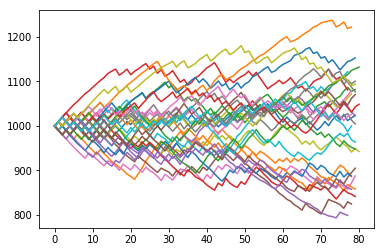

In [445]:
print(X.shape)
print(len(y))
print(len(season))
for t in team_season_stats[2017].keys():
    plt.plot(elo_over_time[2017][t], label=t)
# plt.legend()
# plt.savefig('elos_over_2016.pdf')
plt.show()

 ** Fitting **
 
 now that we have filled our data, features and targets, we can feed this in to scikit learn logistic regression.

In [446]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# This is scikit learn log regression model. 
# We just need to feed it data and train!
model = linear_model.LogisticRegression() 
# random_forest = RandomForestClassifier(n_estimators=100)

season = np.array(season,dtype='int')

# splitting up train and test data
train = np.array(season) != 2017
test = np.array(season) == 2017

model.fit(np.array(X)[train], np.array(y)[train]) #This is the training.
# random_forest.fit(np.array(X)[train], np.array(y)[train])

print('Model done fitting!')
print('Logistic Regression Training Accuracy %.3f'%(model.score(np.array(X)[train,:],np.array(y)[train])))
# print('Random Forest Training Accuracy %.3f'%(random_forest.score(np.array(X)[train,:],np.array(y)[train])))
# print(random_forest.feature_importances_)

Model done fitting!
Logistic Regression Training Accuracy 0.663


 ** Results! **

In [447]:
print ('2017 Season Test Accuracy (Logistic Regression) %.3f'%(model.score(np.array(X)[test,:],np.array(y)[test])))
# print ('2017 Season Test Accuracy (Random Forest) %.3f'%(random_forest.score(np.array(X)[test,:],np.array(y)[test])))

2017 Season Test Accuracy (Logistic Regression) 0.650
